# Subsetting STOFS-3D-Atl Files 
We are subsetting and visualizing the forecast data from STOFS-3D-Atl data.

To begin, load the environment. `source /nhc/Atieh.Alipour/environment/miniconda3/bin/activate  env_subsetting` 

## Modifying Node Connectivity and Dimension Names in filed2d.nc Files 

To facilitate data subsetting using the Thalassa package, we need to make adjustments to the node connectivities and certain dimension names.

## Data Sources:

### Key Bridge Model Outputs
https://noaa-nos-stofs3d-pds.s3.amazonaws.com/index.html#STOFS-3D-Atl-shadow-VIMS/KeyBridgeForecast/20240424/
### STOFS-3D-Atl Operational Output
https://noaa-nos-stofs3d-pds.s3.amazonaws.com/index.html#STOFS-3D-Atl/stofs_3d_atl.20240423/

## Input information

- **Name:** Enter the folder name containing the data you want to read and plot.
- **Date:** Specify the date of the model output you are interested in.

Change the date and filename to explore different dates/files.

In [130]:
#forecast date to visualize
#name        = 'keybridge' 
name        = 'stofs3d' 
date        = '20240423'
save_data   =  False # Change to True if you want to save subset data or you have the subset data saved in your local machine

In [131]:
import dask
import geoviews as gv
import holoviews as hv
import numcodecs
import numpy as np
import pandas as pd
import shapely
import xarray as xr
import matplotlib.pyplot as plt
import s3fs  # Importing the s3fs library for accessing S3 buckets
import time  # Importing the time library for recording execution time
import shapely  # Importing shapely for geometric operations 
import thalassa  # Importing thalassa library for STOFS data analysis
from thalassa import api  # Importing thalassa API for data handling
from thalassa import normalization
from thalassa import utils
from holoviews import opts as hvopts
from holoviews import streams
from holoviews.streams import PointerXY
from holoviews.streams import Tap
import bokeh.plotting as bp
import panel as pn
from os.path import exists


In [132]:
def read_netcdf_from_s3(bucket_name, key):
    """
    Function to read a NetCDF file from an S3 bucket using thalassa API.
    
    Parameters:
    - bucket_name: Name of the S3 bucket
    - key: Key/path to the NetCDF file in the bucket
    
    Returns:
    - ds: xarray Dataset containing the NetCDF data
    """
    s3 = s3fs.S3FileSystem(anon=True)  # Enable anonymous access to the S3 bucket
    url = f"s3://{bucket_name}/{key}"
    ds = xr.open_dataset(s3.open(url, 'rb'), drop_variables=['nvel'])  # Open NetCDF dataset and drop 'nvel' variable
    return ds

In [146]:
def normalize_data(ds):
    """
    Function to modify/normalize a dataset using the Thalassa package.

    Parameters:
    - ds: xarray Dataset containing the data
    
    Returns:
    - normalized_ds: Thalassa dataset ready for cropping or visualizing
    """

    if 'element' in ds:
        normalized_ds = thalassa.normalize(ds)
    elif 'SCHISM_hgrid_face_nodes' in ds:
        # Modify the field2d.nc file based on schout_adcirc.nc file
        ds = ds.rename({'nSCHISM_hgrid_node': 'node', 'nSCHISM_hgrid_face': 'nele', 'nMaxSCHISM_hgrid_face_nodes': 'nvertex', 'SCHISM_hgrid_face_nodes':'element'})
        ds = ds.rename({'SCHISM_hgrid_node_x': 'x', 'SCHISM_hgrid_node_y': 'y'})

        # Normalize data
        normalized_ds = thalassa.normalize(ds)

    return normalized_ds

In [147]:
def subset_thalassa(ds, box):
    """
    Function to subset a thalassa Dataset based on a bounding box using shapely.
    
    Parameters:
    - ds: thalassa Dataset containing the data
    - box: Tuple representing the bounding box (x_min, x_max, y_min, y_max)
    
    Returns:
    - new_ds: Subset of the input dataset within the specified bounding box
    """
    bbox = shapely.box(box[0], box[2], box[1], box[3])  # Create a shapely box from the bounding box coordinates
    new_ds = thalassa.crop(ds, bbox)  # Crop the dataset using the bounding box
    return new_ds


In [148]:

def save_subset_to_netcdf(xarray_ds, output_file):
    """
    Function to save a subset of an xarray Dataset to a NetCDF file.
    
    Parameters:
    - xarray_ds: Subset of the xarray Dataset
    - output_file: Path to save the output NetCDF file
    """
    xarray_ds.to_netcdf(output_file)  # Save the subset to a NetCDF file



## 1. Read and Subset Data on the Fly
The following lines of code read data, normalize it, and subset the data. Alternatively, they read the data from the local machine if the subset data already exists..


In [149]:
output_file = name+date+'.nc'

if name == 'keybridge' :
    base_key = f'STOFS-3D-Atl-shadow-VIMS/KeyBridgeForecast/{date}'
    filename = 'schout_UV4.5m_20240423.nc'
    schout   = 'schout_'
else:
    base_key = f'STOFS-3D-Atl/stofs_3d_atl.{date}'
    filename = 'stofs_3d_atl.t12z.f001_024.field2d.nc'
    schout   = 'schout_adcirc_'

if not exists(output_file):
    start_time = time.time()  # Record the start time
    
    bucket_name = 'noaa-nos-stofs3d-pds'
    key = f'{base_key}/{filename}'
    dataset = read_netcdf_from_s3(bucket_name, key)  # Read NetCDF data from S3 bucket
    
    end_time = time.time()  # Record the end time
    execution_time = end_time - start_time  # Calculate execution time
    print(f"Execution time for reading data: {execution_time} seconds")  # Print execution time


Execution time for reading data: 4.39091682434082 seconds


In [150]:
if not exists(output_file):
    #Prepare data for subsetting and visualization
    start_time = time.time()  # Record the start time
    normalize_dataset = normalize_data(dataset)
    end_time = time.time()  # Record the end time
    execution_time = end_time - start_time  # Calculate execution time
    print(f"Execution time for normalizing: {execution_time} seconds")  # Print execution time


Execution time for normalizing: 1.7294716835021973 seconds


In [151]:
if not exists(output_file):
    # Subset Data
    start_time = time.time()  # Record the start time
    
    # Define the bounding box
    box = (-76.6, -76.4, 39.1, 39.3)
    
    ds2 = subset_thalassa(normalize_dataset, box)  # Subset the thalassa dataset
    
    end_time = time.time()  # Record the end time
    execution_time = end_time - start_time  # Calculate execution time
    print(f"Execution time for subsetting: {execution_time} seconds")  # Print execution time


Execution time for subsetting: 1.6652421951293945 seconds


In [152]:
if save_data == True and not exists(output_file):
      start_time = time.time()  # Record the start time
      save_subset_to_netcdf(ds2, output_file)  # Save the subset to a NetCDF file
      end_time = time.time()  # Record the end time
      execution_time = end_time - start_time  # Calculate execution time
      print(f"Execution time for writing: {execution_time} seconds")  # Print execution time
elif save_data == True and exists(output_file):
      start_time = time.time()  # Record the start time
      ds2 = xr.open_dataset(output_file)
      end_time = time.time()  # Record the end time
      execution_time = end_time - start_time  # Calculate execution time
      print(f"Execution time for reading data from the local machine: {execution_time} seconds")  # Print execution time


# 2- Estimate Current Magnitude and Direction

One of the variables that we are interested in is current. We want to visualize both current magnitude and direction. 

Here, we first estimate these values for the subset data and save them in the same dataset.

In [153]:
ds2

<xarray.Dataset> Size: 63MB
Dimensions:        (time: 24, node: 1024, face: 5039151, max_no_vertices: 3,
                    triface: 1625, three: 3)
Coordinates:
  * time           (time) datetime64[ns] 192B 2024-04-23T13:00:00 ... 2024-04...
Dimensions without coordinates: node, face, max_no_vertices, triface, three
Data variables: (12/16)
    lon            (node) float64 8kB -76.54 -76.54 -76.54 ... -76.4 -76.4
    lat            (node) float64 8kB 39.11 39.11 39.11 ... 39.29 39.29 39.3
    face_nodes     (face, max_no_vertices) int32 60MB 2 9 4 ... 2653939 2653938
    depth          (node) float32 4kB ...
    elev           (time, node) float64 197kB ...
    temp_surface   (time, node) float64 197kB ...
    ...             ...
    vvel_surface   (time, node) float64 197kB ...
    uvel_bottom    (time, node) float64 197kB ...
    vvel_bottom    (time, node) float64 197kB ...
    uvel4.5        (time, node) float64 197kB ...
    vvel4.5        (time, node) float64 197kB ...
    triface_nodes  (triface, three) int32 20kB 0 1 2 3 2 ... 1023 1021 1022 1019
Attributes:
    title:       SCHISM Model output
    source:      SCHISM model output version v10
    references:  http://ccrm.vims.edu/schismweb/

In [154]:
# Calculate magnitude using Pythagorean theorem
ds2['uv_mag_surface'] = np.sqrt(ds2['uvel_surface']**2 + ds2['vvel_surface']**2)

ds2['uv_mag_surface_max'] = ds2['uv_mag_surface'].max(axis=0)

# Calculate angle in radians using arctangent (atan2)
# calculates the angle relative to the positive y-axis 
angle_rad = np.pi / 2 - np.arctan2(-ds2['vvel_surface'], -ds2['uvel_surface'])

# Convert angle from radians to degrees
ds2['uv_angle_deg'] = np.degrees(angle_rad)


In [155]:
ds2

<xarray.Dataset> Size: 63MB
Dimensions:             (time: 24, node: 1024, face: 5039151,
                         max_no_vertices: 3, triface: 1625, three: 3)
Coordinates:
  * time                (time) datetime64[ns] 192B 2024-04-23T13:00:00 ... 20...
Dimensions without coordinates: node, face, max_no_vertices, triface, three
Data variables: (12/19)
    lon                 (node) float64 8kB -76.54 -76.54 -76.54 ... -76.4 -76.4
    lat                 (node) float64 8kB 39.11 39.11 39.11 ... 39.29 39.3
    face_nodes          (face, max_no_vertices) int32 60MB 2 9 ... 2653938
    depth               (node) float32 4kB ...
    elev                (time, node) float64 197kB ...
    temp_surface        (time, node) float64 197kB ...
    ...                  ...
    uvel4.5             (time, node) float64 197kB ...
    vvel4.5             (time, node) float64 197kB ...
    triface_nodes       (triface, three) int32 20kB 0 1 2 3 ... 1021 1022 1019
    uv_mag_surface      (time, node) float64 197kB 0.0 0.0 0.0 ... nan nan nan
    uv_mag_surface_max  (node) float64 8kB 0.0 0.0 0.0 0.0 ... nan nan nan nan
    uv_angle_deg        (time, node) float64 197kB 270.0 270.0 270.0 ... nan nan
Attributes:
    title:       SCHISM Model output
    source:      SCHISM model output version v10
    references:  http://ccrm.vims.edu/schismweb/

# 3- Plotting

Plotting different variables of interest.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
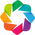

In [156]:

#ds2 = xr.open_dataset('./20240328/stofs_3d_atl.t12z.f025_048.field2d.nc') If you are reading data from your local machine
hv.extension("bokeh")



In [157]:
#vectorfield = gv.VectorField((ds['lon'], ds['lon'], 1000 * ds['uv_ang_surface'][1,:], ds['uv_mag_surface'][1,:]))


#variable, layer, timestamp = "uv_mag_surface", None, ds2.time.values[4]
variable, layer, timestamp = "uv_mag_surface_max", None, ds2.time.values[0]


# The trimesh is the most basic object. This is what you need to create all the others graphs
# It is on this object that you specify the timestamp and/or the layer.
trimesh = api.create_trimesh(ds2.sel(time=timestamp), variable=variable)

# The wireframe is the representation of the mesh
wireframe = api.get_wireframe(trimesh)

# The tiles is using the tiling service from Open Street maps
tiles =  api.get_tiles() 

# The raster object is the basic Map that visualizes the variable. 
# You can specify things like the colorbar limits and/or the extents
raster = api.get_raster(trimesh, clim_min=0, clim_max=0.5)
#raster = api.get_raster(trimesh)

# The pointer/tap timeseries extract the timeseries of a specific node from the xr.Dataset and visualize it.
pointer_dmap = api.get_pointer_timeseries(ds=ds2, variable=variable, source_raster=raster)

# Create and customize the magnitude timeseries plot
tap_dmap_uv_mag = api.get_tap_timeseries(ds=ds2, variable='uv_mag_surface', source_raster=raster)
tap_dmap_uv_mag.opts(
    width=440, height=300, title="Magnitude",
    xlabel="Time",  # Use default if units not present
    ylabel="velocity (m/s)"
)

# Create and customize the angle timeseries plot
tap_dmap_uv_ang = api.get_tap_timeseries(ds=ds2, variable='uv_angle_deg', source_raster=raster)
tap_dmap_uv_ang.opts(
    width=440, height=300, title="Angle",
    xlabel="Time",  # Use default if units not present
    ylabel="Angle (degrees)"
)

lat_br_mid =  39.217192
lon_br_mid = -76.528318
Key_bridge = ( lon_br_mid,lat_br_mid , 'KeyBrj')
kb = gv.Points([Key_bridge], vdims='Brj.').opts(color="red", marker="circle_dot", size=4)



In [159]:
raster_layout = tiles * raster.opts(width=400, height = 450, cmap="jet", title="Max surface current magnitude (m/s)")
lay = raster_layout * wireframe  * kb + tap_dmap_uv_mag.opts() + tap_dmap_uv_ang.opts()
lay
#lay.servable()

:Layout
   .DynamicMap.I   :DynamicMap   []
      :Overlay
         .WMTS.I   :WMTS   [Longitude,Latitude]
         .Image.I  :Image   [lon,lat]   (lon_lat uv_mag_surface_max)
         .Image.II :Image   [lon,lat]   (lon_lat Count)
         .Points.I :Points   [Longitude,Latitude]   (Brj.)
   .DynamicMap.II  :DynamicMap   []
      :Curve   [time]   (uv_mag_surface)
   .DynamicMap.III :DynamicMap   []
      :Curve   [time]   (uv_angle_deg)

In [ ]:
# Convert the interactive plot to a Bokeh figure
#bokeh_figure = hv.render(lay, backend='bokeh')

# Specify the output file
#bp.output_file("FrancisScottKeyBridge_Current.html")

# Save the Bokeh figure
#bp.save(bokeh_figure)


dashboard = pn.Column(
    pn.Row('###  Francis ScottKey Bridge \n Current Velocity Dashboard'),
    pn.Row(
        pn.Column(
            pn.Row(
                raster_layout * wireframe  * kb #*\
                #rasterized0.opts(opts.Image(width=500, height=400, logz=False, xaxis=None, yaxis=None, tools=['hover'],\
                #colorbar=True,alpha=0.6,cmap=cmap,clim= clim   )) * 
                #hwm_po
               
            ),
            pn.Row(
                 tap_dmap_uv_mag.opts()
            ),
                        pn.Row(
                 tap_dmap_uv_ang.opts()
            ),
        ),
        #pn.Column( hwm_mo.to(hv.Scatter,['adcirc','hwm']).opts(width=300, logy=False, tools=['hover'],aspect=1,size=5,alpha=0.6,color='k')
)
    )
